# Fitting capillary pressure to centrifuge data

In [1]:
# read the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.optimize import root
import time

sys.path.append('..')
import pymadreq.coreflood as cf

from importlib import reload
from pyfvtool import *
from scipy.optimize import root
from tqdm import tqdm
from CoolProp.CoolProp import PropsSI

import pymadreq.coreflood as cf
import pymadreq.fractional_flow as ff
import pymadreq.IO as IO

reload(ff)
reload(cf)
reload(IO)

# read the data
df = pd.read_csv('pc_data_chalk_sw.csv')
sns.set_style('whitegrid')


[Text(0.5, 0, 'Water saturation'), Text(0, 0.5, 'Capillary pressure (kPa)')]

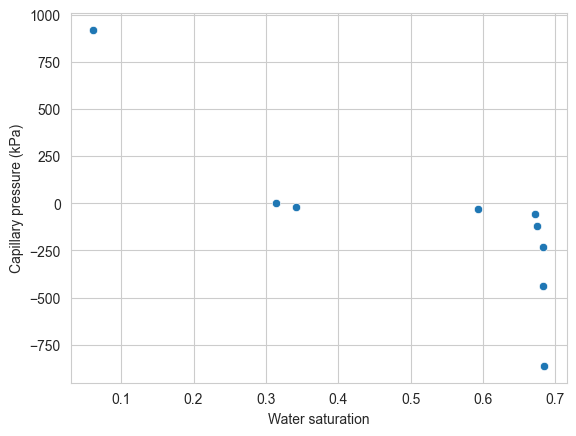

In [2]:
pc_plot = sns.scatterplot(df, x='sw', y='pc')
pc_plot.set(xlabel='Water saturation', ylabel='Capillary pressure (kPa)')

Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
pc_hm      5e+04     5000    5e+04     40.8     True     None     None
pc_lm      -5000   -5e+05    -5000 0.005381     True     None     None
pc_max  9.193e+05    8e+04    2e+06        0    False     None     None
pc_min  -8.621e+05   -1e+06   -6e+04        0    False     None     None
sw_pc0    0.3144      0.3      0.6        0    False     None     None


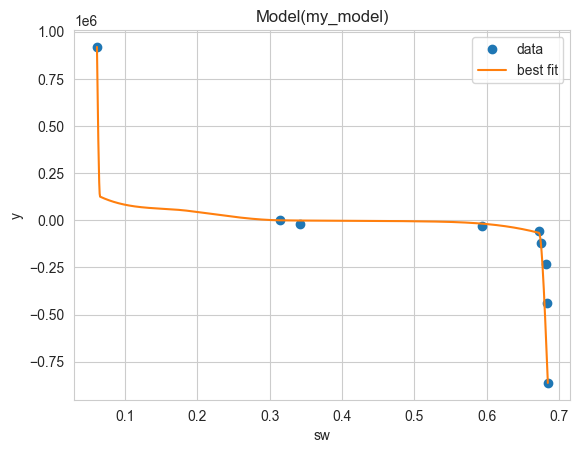

In [3]:
from lmfit import Parameters, Model

swc = df['sw'].min()
sor = 1-df['sw'].max()

def my_model(sw, sw_pc0, pc_lm, pc_hm, pc_min, pc_max):
    pc = cf.CapillaryPressurePiecewise(
        sw_pc0= sw_pc0,
        pce= 5e5,
        sorting_factor= 2.0,
        pc_min= pc_min,
        pc_max= pc_max,
        pc_lm= pc_lm,
        pc_hm= pc_hm,
        swc= swc,
        sor= sor,
        extrap_factor= 200.0,
        curve_factor_l= 15.0,
        curve_factor_h= 30.0)
    return pc.pc_imb(sw)
    
model = Model(my_model)

params = Parameters()
params.add('sw_pc0', value=df['sw'][df['pc']==0].values[0], min=0.3, max=0.6, vary=False)
params.add('pc_lm', value=-1e4, min=-5e5, max=-5e3, vary=True)
params.add('pc_hm', value=2e4, min=5e3, max=5e4, vary=True)
params.add('pc_min', value=1000*df['pc'].min(), min=-1e6, max=-6e4, vary=False)
params.add('pc_max', value=1000*df['pc'].max(), min=8e4, max=2e6, vary=False)

result = model.fit(1000*df['pc'].to_numpy(), params, sw=df['sw'].to_numpy(), verbose=2, method='nelder')
result.plot_fit(numpoints=1000, datafmt='o', fitfmt='-')
result.params.pretty_print()

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
labda_o      4.366        1        8     None     True     None     None
labda_w      2.699        1        8     None     True     None     None
pc_max_o     1e+15    5e+05    1e+15     None     True     None     None
pc_max_w     1e+15    5e+05    1e+15     None     True     None     None
pce_o     7.803e+04    1e+04    3e+05     None     True     None     None
pce_w     5.554e+04    1e+04    3e+05     None     True     None     None


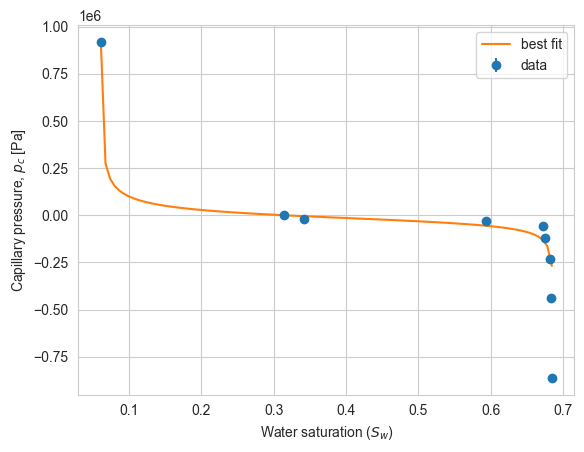

In [4]:
from lmfit import Parameters, Model

swc = df['sw'].min()
sor = 1-df['sw'].max()

def my_model2(sw, pce_w, pce_o, labda_w, labda_o, pc_max_o, pc_max_w):
    pc = cf.CapillaryPressureBrooksCorey(
        swc= swc,
        sor= sor,
        pce_w= pce_w,
        pce_o=pce_o,
        labda_o= labda_o,
        labda_w= labda_w,
        pc_max_o=pc_max_o,
        pc_max_w=pc_max_w
    )
    return pc.pc_imb(sw)
    
model2 = Model(my_model2)

params = Parameters()
params.add('pce_w', value=1e5, min=1e4, max=3e5, vary=True)
params.add('pce_o', value=1e5, min=1e4, max=3e5, vary=True)
params.add('labda_o', value=2.0, min=1.0, max=8)
params.add('labda_w', value=2.0, min=1.0, max=8)
params.add('pc_max_o', value=-10000*1000*df['pc'].min(), min=5e5, max=1e15, vary=True)
params.add('pc_max_w', value=10000*1000*df['pc'].max(), min=5e5, max=1e15, vary=True)
w = np.ones_like(df['pc'])
w[df['pc']==0] = 50
w[-5] = 5
w[-1] = 1
result2 = model2.fit(1000*df['pc'].to_numpy(), params, sw=df['sw'].to_numpy(), verbose=2, method='powell', weights=w)
result2.plot_fit(numpoints=100, datafmt='o', fitfmt='-')
plt.xlabel('Water saturation ($S_w$)')
plt.ylabel('Capillary pressure, $p_c$ [Pa]')
plt.title('')
result2.params.pretty_print()

Text(0, 0.5, 'Capillary pressure, $p_c$ [Pa]')

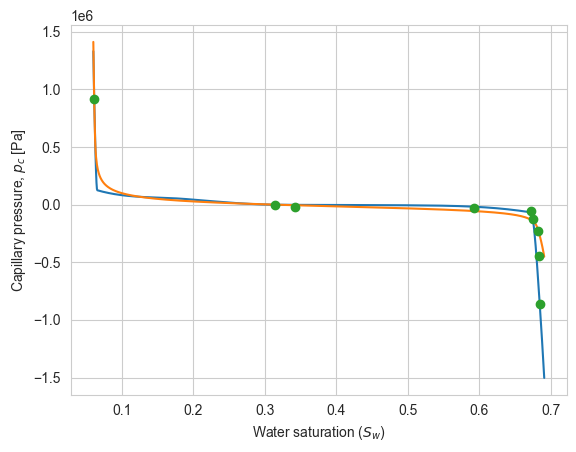

In [5]:
sw_temp = np.linspace(0.98*swc, 1-0.98*sor, 1000)
pc_piece = model.eval(params=result.params, sw=sw_temp)
pc_corey = model2.eval(params=result2.params, sw=sw_temp)
plt.plot(sw_temp, pc_piece, label='Piecewise')
plt.plot(sw_temp, pc_corey, label='Corey')
plt.plot(df['sw'], 1000*df['pc'], 'o')
# plt.yscale('symlog')
plt.xlabel('Water saturation ($S_w$)')
plt.ylabel('Capillary pressure, $p_c$ [Pa]')

Text(0, 0.5, 'Capillary pressure, $p_c$ [Pa]')

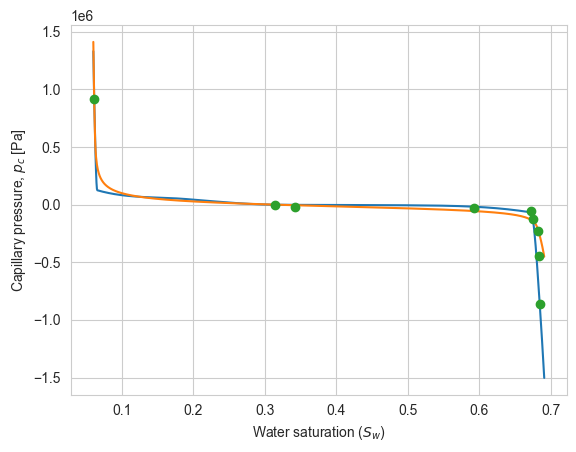

In [6]:
plt.plot(sw_temp, pc_piece, label='Piecewise')
plt.plot(sw_temp, pc_corey, label='Corey')
plt.plot(df['sw'], 1000*df['pc'], 'o')
# plt.yscale('symlog')
plt.xlabel('Water saturation ($S_w$)')
plt.ylabel('Capillary pressure, $p_c$ [Pa]')

# Use in simulation
Now, I try both Pc's in the simulation of a SI test (imaginary).

In [7]:
data = IO.read_json("../examples/sample.json")
rel_perm_ww, rel_perm_ow, pc_ww, pc_ow = IO.read_transport_functions(data)
core_plug = IO.read_core_properties(data)
fluids = IO.read_fluids(data)
IC = IO.read_initial_conditions(data) # initial conditions
BC = IO.createFloodingCondition(data["BC"]) # boundary conditions
numerical_params = IO.read_numerical_settings(data)
m = IO.read_flooding_domain(data)

In [8]:
pc_p = cf.CapillaryPressurePiecewise(
        sw_pc0= result.params['sw_pc0'].value,
        pce= 5e5,
        sorting_factor= 2.0,
        pc_min= result.params['pc_min'].value,
        pc_max= result.params['pc_max'].value,
        pc_lm= result.params['pc_lm'].value,
        pc_hm= result.params['pc_hm'].value,
        swc= swc,
        sor= sor,
        extrap_factor= 200.0,
        curve_factor_l= 15.0,
        curve_factor_h= 30.0)

pc_c = cf.CapillaryPressureBrooksCorey(
        swc= swc,
        sor= sor,
        pce_w= result2.params['pce_w'].value,
        pce_o=result2.params['pce_o'].value,
        labda_o= result2.params['labda_o'].value,
        labda_w= result2.params['labda_w'].value,
        pc_max_o=result2.params['pc_max_o'].value,
        pc_max_w=result2.params['pc_max_w'].value
    )

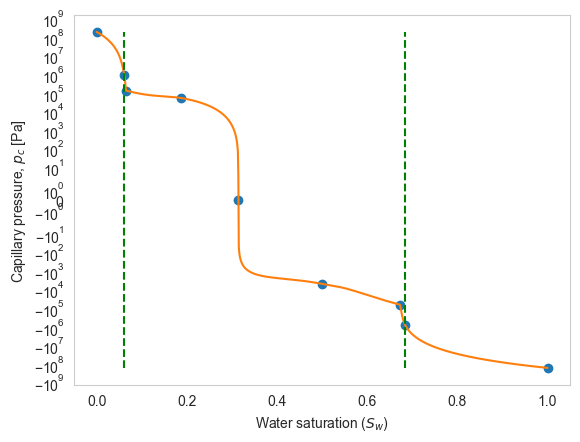

In [9]:
plt.plot(pc_p.imb_points[:,0], pc_p.imb_points[:,1], 'o')
sw_t = np.linspace(0.0, 1.0, 1000)
pc_imb_val = pc_p.pc_imb(sw_t)
plt.plot(sw_t, pc_imb_val, label='Piecewise')
plt.plot([swc, swc], [pc_imb_val.min(), pc_imb_val.max()], 'g--')
plt.plot([1-sor, 1-sor], [pc_imb_val.min(), pc_imb_val.max()], 'g--')
plt.yscale('symlog')
plt.xlabel('Water saturation ($S_w$)')
plt.ylabel('Capillary pressure, $p_c$ [Pa]')
plt.grid(False)

In [10]:
numerical_params.simulation_time = 100000.
numerical_params.time_step = 100.
cf2d_imb = cf.CoreImbibition(rel_perm_ww, pc_p, pc_p, core_plug, 
                             fluids, IC, BC, numerical_params, Nx=20, Nr = 5)
start_time = time.time()
t_num, R_num = cf2d_imb.simulate_no_film()
end_time = time.time()
print('Elapsed time of piecewise:', end_time - start_time, 'seconds')
cf2d_imb_corey = cf.CoreImbibition(rel_perm_ww, pc_c, pc_c, core_plug, 
                             fluids, IC, BC, numerical_params, Nx=20, Nr = 5)
start_time = time.time()
t_num_corey, R_num_corey = cf2d_imb_corey.simulate_no_film()
end_time = time.time()
print('Elapsed time of corey:', end_time - start_time, 'seconds')

c:\Users\aaeft\venvs\myfvm\Lib\site-packages\pyfvtool\cell.py:97: RuntimeWarning: invalid value encountered in divide
  return CellVariable(self.domain, self.value/other.value)
  0%|          | 0/100000.0 [00:00<?, ?it/s]

c:\Users\aaeft\Documents\GitHub\PyMADREQ\examples\..\pymadreq\coreflood.py:1373: RuntimeWarning: invalid value encountered in divide
  sw_old, dt, RHS_sw / self.porosity.value.ravel(), self.saturation_bc
191248.8802562608it [00:00, 195596.60it/s]                              


Elapsed time of piecewise: 1.0007970333099365 seconds


181019.89683093622it [00:02, 86700.84it/s]                              

Elapsed time of corey: 2.0994045734405518 seconds


# Simulation of a real case

In [11]:
df_core = pd.read_excel("E-31-imbibitions-formatted.xlsx", sheet_name="core")
df_oil = pd.read_excel("E-31-imbibitions-formatted.xlsx", sheet_name="oil")
df_cond = pd.read_excel("E-31-imbibitions-formatted.xlsx", sheet_name="condition")
df_imb = pd.read_excel("E-31-imbibitions-formatted.xlsx", sheet_name="SW")
core_dics = df_core.set_index('parameter')['value'].to_dict()
oil_dict = df_oil.set_index('property')['value'].to_dict()
cond_dict = df_cond.set_index('parameter')['value'].to_dict()
BC.production_pressure = cond_dict['back_pressure']*1e5 # Pa
T = cond_dict['temperature'] + 273.15 # K

core_plug.core_length = core_dics['L']/100 # m
core_plug.core_diameter = core_dics['D']/100 # m
core_plug.porosity = core_dics['porosity']
core_plug.permeability = core_dics['perm_water']*1e-15 # m2
core_plug.pore_volume = core_dics['pore_volume']/1e6 # m3
core_plug.cross_sectional_area = core_plug.core_diameter**2*np.pi/4 # m2

fluids.oil_density = oil_dict['density'] # kg/m3
fluids.oil_viscosity = oil_dict['viscosity'] # Pa.s
fluids.water_density = PropsSI('D', 'T', T, 'P', BC.production_pressure, 'water') # kg/m3
fluids.water_viscosity = PropsSI('V', 'T', T, 'P', BC.production_pressure, 'water') # Pa.s

IC.sw = 1 - core_dics['Soi']
IC.p = BC.production_pressure
IC.T = T
t_imb = 3600*df_imb['Time (hr)'].to_numpy() # hr to s
RF_imb = df_imb['RF (%)'].to_numpy()/100 # % to fraction

In [13]:
core_plug.permeability

1.0700000000000002e-15

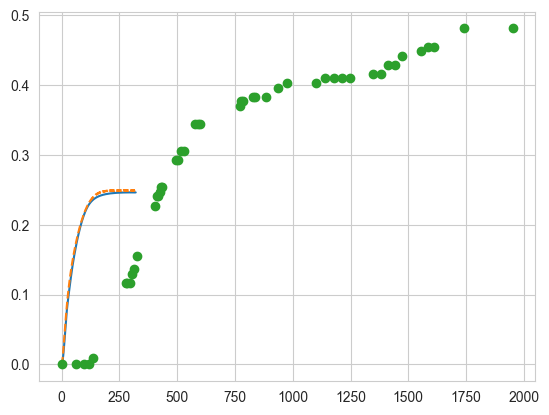

In [14]:
plt.plot(np.sqrt(t_num), R_num)
plt.plot(np.sqrt(t_num_corey), R_num_corey, '--')
plt.plot(np.sqrt(t_imb), RF_imb, 'o')

In [16]:
numerical_params.simulation_time = 0.05*t_imb[-1]
# assign fitted relperm parameters
rel_perm_ww.krw0 = 0.1763082
rel_perm_ww.no = 2.68964890
rel_perm_ww.nw = 1.93153404
rel_perm_ww.sor = sor # 0.2 # 0.37729816
rel_perm_ww.swc = swc # 0.1971
rel_perm_ww.kro0 = 0.83903614

pc_p = cf.CapillaryPressurePiecewise(
        sw_pc0= 0.6, #result.params['sw_pc0'].value,
        pce= 5e5,
        sorting_factor= 2.0,
        pc_min= result.params['pc_min'].value,
        pc_max= result.params['pc_max'].value,
        pc_lm= -1e3, #result.params['pc_lm'].value,
        pc_hm= 1e3, # result.params['pc_hm'].value,
        swc= swc,
        sor= sor,
        extrap_factor= 200.0,
        curve_factor_l= 20.0,
        curve_factor_h= 20.0)

pc_p_old = cf.CapillaryPressurePiecewise(
        sw_pc0= 0.3, #result.params['sw_pc0'].value,
        pce= 5e5,
        sorting_factor= 2.0,
        pc_min= result.params['pc_min'].value,
        pc_max= result.params['pc_max'].value,
        pc_lm= -1e3, #result.params['pc_lm'].value,
        pc_hm= 1e3, # result.params['pc_hm'].value,
        swc= swc,
        sor= sor,
        extrap_factor= 200.0,
        curve_factor_l= 20.0,
        curve_factor_h= 20.0)

numerical_params.time_step = 100.0
cf2d_imb = cf.CoreImbibition(rel_perm_ww, pc_p_old, pc_p, core_plug, 
                             fluids, IC, BC, numerical_params, Nx=10, Nr = 15, L_film=1e-6)



  0%|          | 0/4185719.99999977 [00:00<?, ?it/s]

9077117.534892762it [00:05, 1555016.37it/s]                                       


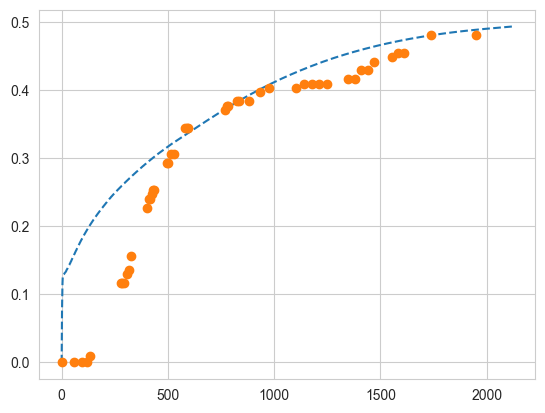

In [17]:
numerical_params.simulation_time = 1.1*t_imb[-1]
cf2d_imb_fit = cf.CoreImbibition(rel_perm_ww, pc_p, pc_p, core_plug, 
                             fluids, IC, BC, numerical_params, Nx=10, Nr = 15, L_film=1e-6)
t_fit, R_fit = cf2d_imb_fit.simulate_no_film()
plt.plot(np.sqrt(t_fit), R_fit, '--')
plt.plot(np.sqrt(t_imb), RF_imb, 'o')

  0%|          | 0/4185719.99999977 [00:00<?, ?it/s]

c:\Users\aaeft\Documents\GitHub\PyMADREQ\examples\..\pymadreq\coreflood.py:1257: RuntimeWarning: invalid value encountered in divide
  sw_old, dt, RHS_sw / self.porosity.value.ravel(), self.saturation_bc
5040252.550970708it [58:31, 1435.45it/s]                                         


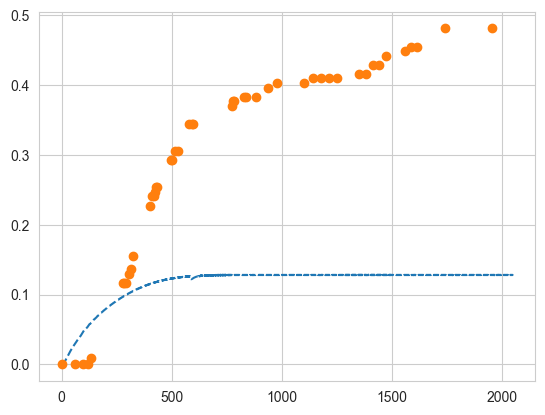

In [18]:
numerical_params.simulation_time = 1.1*t_imb[-1]
cf2d_imb_fit = cf.CoreImbibition(rel_perm_ww, pc_p_old, pc_p, core_plug, 
                             fluids, IC, BC, numerical_params, Nx=10, Nr = 15, 
                             L_film=300e-6, D_film=1e-13)
t_fit, R_fit = cf2d_imb_fit.simulate()
plt.plot(np.sqrt(t_fit), R_fit, '--')
plt.plot(np.sqrt(t_imb), RF_imb, 'o')

In [262]:
t_sim, R_sim = cf2d_imb.simulate()
plt.plot(np.sqrt(t_sim), R_sim)
plt.plot(np.sqrt(t_imb), RF_imb, 'o')

  0%|          | 0/4185719.99999977 [00:00<?, ?it/s]

c:\Users\aaeft\Documents\GitHub\PyMADREQ\examples\..\pymadreq\coreflood.py:1257: RuntimeWarning: invalid value encountered in divide
  sw_old, dt, RHS_sw / self.porosity.value.ravel(), self.saturation_bc
 13%|█▎        | 561601.4346883034/4185719.99999977 [06:09<39:46, 1518.68it/s]   


KeyboardInterrupt: 

  0%|          | 0/1000000.0 [00:00<?, ?it/s]

1033931.6827962624it [00:03, 296524.75it/s]                               


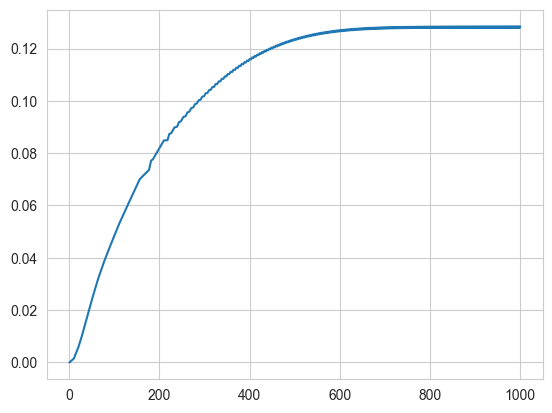

In [263]:
# plt.plot(pc_p.imb_points[:,0], pc_p.imb_points[:,1], 'o')
pc_p = cf.CapillaryPressurePiecewise(
        sw_pc0= 0.6, #result.params['sw_pc0'].value,
        pce= 5e5,
        sorting_factor= 2.0,
        pc_min= result.params['pc_min'].value,
        pc_max= result.params['pc_max'].value,
        pc_lm= -1e3, #result.params['pc_lm'].value,
        pc_hm= 1e3, # result.params['pc_hm'].value,
        swc= swc,
        sor= sor,
        extrap_factor= 200.0,
        curve_factor_l= 10.0,
        curve_factor_h= 10.0)
pc_p_old = cf.CapillaryPressurePiecewise(
        sw_pc0= 0.3, #result.params['sw_pc0'].value,
        pce= 5e5,
        sorting_factor= 2.0,
        pc_min= result.params['pc_min'].value,
        pc_max= result.params['pc_max'].value,
        pc_lm= -1e3, #result.params['pc_lm'].value,
        pc_hm= 1e3, # result.params['pc_hm'].value,
        swc= swc,
        sor= sor,
        extrap_factor= 200.0,
        curve_factor_l= 10.0,
        curve_factor_h= 10.0)
sw_t = np.linspace(swc, 1.0-sor, 1000)
pc_imb_val = pc_p_old.pc_imb(sw_t)
# plt.plot(sw_t, pc_imb_val, label='Piecewise')
numerical_params.simulation_time = 1000000.
numerical_params.time_step = 100.
cf2d_imb = cf.CoreImbibition(rel_perm_ww, pc_p_old, pc_p_old, core_plug, 
                             fluids, IC, BC, numerical_params, Nx=10, Nr = 10)
start_time = time.time()
t_num, R_num = cf2d_imb.simulate_no_film()
end_time = time.time()
plt.plot(np.sqrt(t_num), R_num)

In [272]:
# no use the previous run and continue the simulation
numerical_params.simulation_time = 300000.
cf2d_imb2 = cf.CoreImbibition(rel_perm_ww, pc_p, pc_p_old, core_plug, 
                             fluids, IC, BC, numerical_params, Nx=10, Nr = 10, 
                             D_film=1e-15, L_film=300e-6)
cf2d_imb2.initial_sw.update_value(cf2d_imb.final_sw)

In [273]:
t2, R2 = cf2d_imb2.simulate()

  0%|          | 0/300000.0 [00:00<?, ?it/s]

416558.9004181662it [00:24, 16849.00it/s]                               


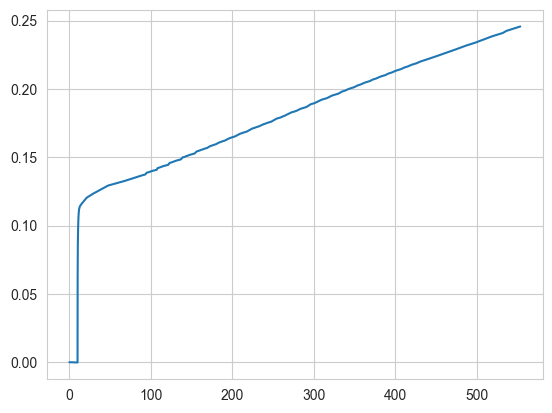

In [274]:
plt.plot(np.sqrt(t2), R2)

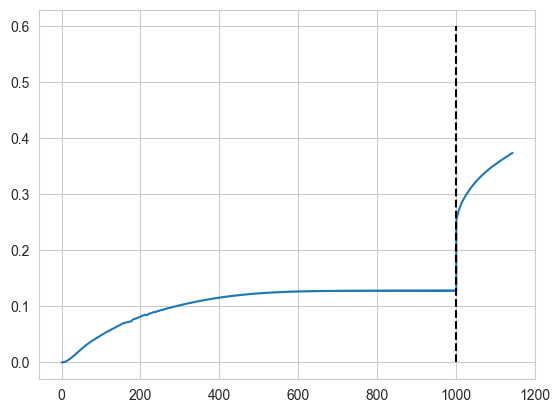

In [275]:
plt.plot(np.sqrt(np.hstack([t_num, t_num[-1]+t2])), 
                 np.hstack([R_num, R_num[-1]+R2]))
plt.plot([np.sqrt(t_num[-1]), np.sqrt(t_num[-1])], [0, 0.6], 'k--')

In [ ]:
np.sqrt(t_num[-1])

1000.9173013937809